In [1]:
import os
os.chdir("/home/nickj/vl-hallucination")
os.environ["CUDA_VISIBLE_DEVICES"]="5"
# os.environ["CUDA_LAUNCH_BLOCKING"]="1"
device = "cuda"
device1 = "cuda:1"

In [2]:
from src.gpt.utils import map_hallucination_annotations_to_words
import json
from sklearn.decomposition import SparseCoder

import requests
from PIL import Image
import pickle
from io import BytesIO
import numpy as np
import sys
import spacy
import pandas as pd

import matplotlib.pyplot as plt
import requests
import random
from PIL import Image
from io import BytesIO
import torch
from transformers import LlamaTokenizer
from tqdm import tqdm
import time
import multiprocessing
from multiprocessing import Pool, Process, Queue
# from experiments.embeddings import captioner, load_image, get_image_embeddings, get_vocab_embeddings

/home/nickj/miniconda3/envs/vl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
res = torch.load("/home/nickj/vl-hallucination/vl_data/llava7B_train.pt")

In [6]:
h_ids = []
for coco_img in res:
  if len(res[coco_img]["chair_evals"]["mscoco_hallucinated_words"]) > 0:
    h_ids.append(coco_img)

In [8]:
torch.save(h_ids, "/home/nickj/vl-hallucination/vl_data/llava7B_train_ids_with_hallucinations.pt")

In [10]:

with open("/home/nickj/vl-hallucination/data/coco/dataset_coco.json", "r") as f:
  coco_data = json.load(f)

train_objs = []
for coco_obj in coco_data["images"]:
  img_path = coco_img_id_to_path(coco_obj["imgid"], validation=False)
  if not os.path.exists(img_path):
    continue
  evals = evaluator.compute_hallucinations(coco_obj["imgid"], "")
  if len(evals["mscoco_gt_words"]) == 0:
    continue

  if coco_obj["split"] == "train":
    train_objs.append(coco_obj)

In [12]:
random_train_objs = random.sample(train_objs, 5000)

output_file_path = "/home/nickj/vl-hallucination/data/coco/train_objs_5K.json"
with open(output_file_path, "w") as outfile:
  json.dump(random_train_objs, outfile, indent=4)


In [15]:
import os

directory_path = "/home/nickj/vl-hallucination/data/coco/train2014/"
num_files = len([name for name in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, name))])
num_files

16351

In [2]:
with open("/home/nickj/vl-hallucination/data/coco/train_objs_5K.json", "r") as f:
    coco_data = json.load(f)

total = 0
issues = 0
for obj in coco_data:
    img_path = coco_img_id_to_path(obj["imgid"], validation=False)
    res = evaluator.compute_hallucinations(obj["imgid"], "")
    if len(res["mscoco_gt_words"]) == 0:
        issues += 1
    if not os.path.exists(img_path):
        print(f"Warning: The image path {img_path} does not exist.")
        total += 1
print(total)

0


In [4]:
coco_imgs = []
for coco_obj in coco_data:
  coco_imgs.append(coco_obj["imgid"])

In [6]:
torch.save(coco_imgs, "/home/nickj/vl-hallucination/vl_data/train_coco_img_ids.pt")

In [3]:
issues

3947

In [4]:
import torch

res = torch.load("/home/nickj/vl-hallucination/llava7B_coco.pt")

In [14]:
from experiments.embeddings import coco_img_id_to_path
import shutil
for obj in train_imgs:
    file_name = f"COCO_train2014_{(12 - len(str(obj))) * '0' + str(obj)}"
    img_path = f"/home/nickj/vl-hallucination/data/coco/COCO_2014_YOLOv3_raw/images/train2014/{file_name}.jpg"
    # res = evaluator.compute_hallucinations(obj["imgid"], "")
    if os.path.exists(img_path):
        destination_path = os.path.join("/home/nickj/vl-hallucination/vl_data/train2014", os.path.basename(img_path))
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)

        shutil.move(img_path, destination_path)
    else:
        print(f"Warning: The image path {img_path} does not exist.")
        total += 1

### Setup

In [3]:
def get_unique_collection(collection, return_original = False):
  if return_original:
    return collection
  return list(set(collection))

In [79]:
def compute_eval_diffs(results_collection, total_imgs = 5000):
    coco_classes = torch.load("coco_classes.pt")
    h = [0, 0]
    recall = [0, 0]
    h_before_total = 0
    recall_before_total = 0
    h_after_total = 0
    recall_after_total = 0
    h_intersect_total = 0
    recall_intersect_total = 0
    classes_to_count = dict()
    recall_lost_total = 0
    new_h_total = 0
    lost_h_total = 0
    recall_gained_total = 0
    h_free_images = [0, 0]

    for coco_class in coco_classes:
        classes_to_count[coco_class] = {
        "h_before": 0,
        "h_after": 0,
        "recall_before": 0,
        "recall_after": 0
        }

    examples_good = []
    count = 0
    for coco_img in results_collection:
        count += 1
        h_before, recall_before, h_after, recall_after = results_collection[coco_img]
        for (caption_word, coco_class) in h_before:
            classes_to_count[coco_class]["h_before"] += 1
        for (caption_word, coco_class) in h_after:
            classes_to_count[coco_class]["h_after"] += 1

        for (caption_word, coco_class) in recall_before:
            classes_to_count[coco_class]["recall_before"] += 1
        for (caption_word, coco_class) in recall_after:
            classes_to_count[coco_class]["recall_after"] += 1

        # recall_after_total += len(recall_after)
        # recall_before_total += len(recall_before)
        # h_before_total += len(h_before)
        # h_after_total += len(h_after)

        # if len(h_before) > len(h_after):
        #   check_results.append(coco_img)

        # Calculate hallucination and recall intersections
        h_before_classes = set([ele[1] for ele in h_before])
        h_after_classes = set([ele[1] for ele in h_after])
        recall_before_classes = set([ele[1] for ele in recall_before])
        recall_after_classes = set([ele[1] for ele in recall_after])
        h_intersect_total += len(h_before_classes.intersection(h_after_classes))
        recall_intersect_total += len(recall_before_classes.intersection(recall_after_classes))

        # if len(recall_before_classes) - len(recall_after_classes.intersection(recall_before_classes)) > 0:
        if len(h_after_classes) - len(h_before_classes) < 0 and len(recall_after_classes) >= len(recall_before_classes) and len(h_after_classes) - len(h_after_classes.intersection(h_before_classes)) == 0:
            examples_good.append((coco_img, h_after_classes - h_before_classes.intersection(h_after_classes)))

        new_h_total += len(h_after_classes) - len(h_before_classes.intersection(h_after_classes))
        lost_h_total += len(h_before_classes) - len(h_before_classes.intersection(h_after_classes))

        if len(h_after) == 0:
            h_free_images[1] += 1
        if len(h_before) == 0:
            h_free_images[0] += 1

        recall_after_total += len(recall_after_classes)
        recall_before_total += len(recall_before_classes)
        h_before_total += len(h_before_classes)
        h_after_total += len(h_after_classes)


        # Recall lost - describes the ground truth words that no longer show up as a result of this intervention method. We want this number to be as high as possible
        recall_lost_total += len(recall_before_classes) - len(recall_after_classes.intersection(recall_before_classes))
        recall_gained_total += len(recall_after_classes) - len(recall_after_classes.intersection(recall_before_classes))
    return dict(h_free_images=h_free_images, hallucinations=[h_before_total, h_after_total], chair_i=[1 - h_free_images[0]/total_imgs, 1 - h_free_images[1]/total_imgs], chair_s=[h_before_total / (h_before_total + recall_before_total), h_after_total / (h_after_total + recall_after_total)], recall=[recall_before_total, recall_after_total], hallucinations_gained=new_h_total, hallucinations_lost=lost_h_total, recall_lost=recall_lost_total, recall_gained=recall_gained_total, examples_good=examples_good, classes_to_count=classes_to_count)


# text = f"""
# Hallucinations before: {h_before_total}
# Hallucinations after: {h_after_total} ({100 * h_after_total / h_before_total}% factor)
# Recall before: {recall_before_total}
# Recall after: {recall_after_total}

# New hallucinations: {new_h_total}
# Recall lost: {recall_lost_total}
# Recall gained: {recall_gained_total}
# """
# print(text)


In [5]:
def parse_mentioned_objs(chair_evals):
    mentioned_pairs = chair_evals["mscoco_hallucinated_words"] + chair_evals["recall_words"]
    mentioned_objs = set([pair[0] for pair in mentioned_pairs])
    return mentioned_objs

In [6]:
def parse_h_objs(chair_evals):
    mentioned_pairs = chair_evals["mscoco_hallucinated_words"]
    mentioned_objs = set([pair[0] for pair in mentioned_pairs])
    return mentioned_objs

def parse_recall_objs(chair_evals):
    mentioned_pairs = chair_evals["recall_words"]
    mentioned_objs = set([pair[0] for pair in mentioned_pairs])
    return mentioned_objs

In [7]:
def calc_iou(mo1, mo2):
    if len(mo2) == 0 and len(mo1) > 0:
        return 0
    elif len(mo2) == 0 and len(mo1) == 0:
        return 1

    return len(mo1.intersection(mo2)) / len(mo1.union(mo2))

In [37]:
def merge_experiment_results(directory, startswith):
    merged_results = {}

    for filename in os.listdir(directory):
        if filename.startswith(startswith):
            file_path = os.path.join(directory, filename)
            try:
                print(f"Reading {file_path}")
                data = torch.load(file_path)
                if isinstance(data, dict):
                    for key, value in data.items():
                        if key not in merged_results:
                            merged_results[key] = value
                        else:
                            merged_results[key].update(value)
            except Exception as e:
                print(f"Failed to load {file_path}: {e}")

    return merged_results

### Experiment 9

In [179]:
file = "/home/nickj/vl-hallucination/vl_results/experiment9A_blip7b_w1_ss5000_hFalse_gtTrue_.pt"
results9 = torch.load(file)

if "hTrue_gtTrue" in file:
    mode = "HR"
elif "hFalse_gtTrue" in file:
    mode = "R"
elif "hTrue_gtFalse" in file:
    mode = "H"

if "llava7b" in file:
    model = "llava7b"
elif "blip7b" in file:
    model = "blip7b"
elif "blip13b" in file:
    model = "blip13b"

print(f"MODE: {mode}")
print(f"MODEL: {model}")

MODE: R
MODEL: blip7b


In [180]:
data = torch.load(f"/home/nickj/vl-hallucination/vl_data/{model}_train.pt")

In [187]:
removals = 0
iou = [0, 0]
total = 0
ious = []
for coco_img in results9:
    total += len(results9[coco_img])
    for coco_obj in results9[coco_img]:
        mentioned_objs = parse_mentioned_objs(results9[coco_img][coco_obj]["chair_evals"])
        original_objs = parse_mentioned_objs(data[coco_img]["chair_evals"]) - set([coco_obj])
        new_iou = calc_iou(mentioned_objs, original_objs)
        iou[0] += new_iou
        iou[1] += 1
        ious.append(new_iou)
        if coco_obj not in mentioned_objs:
            removals += 1

In [188]:
print(removals, total, removals/total, iou[0] / iou[1])

680 5478 0.12413289521723257 0.5968918383348809


(array([ 205.,   39.,  235.,  343.,  346., 1477.,  940.,  740.,  933.,
         220.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

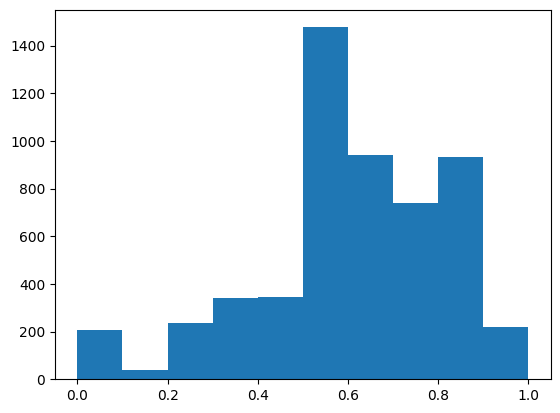

In [189]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(np.array(ious), bins = 10)

In [12]:
results9[106637]

{'chair': {'caption': "<s> In the scene, a young boy is swinging a baseball bat at a pitched ball during a game of baseball. He is positioned near the batter's box, and the ball appears to be in mid-air as he prepares to hit it. There are several other people in the vicinity, some of whom are watching the game and others who appear to be waiting for their turn to play. A few chairs can be seen scattered around the field, possibly belonging to the players or spectators. The overall atmosphere is lively and engaging, showcasing the excitement of a youth baseball game.",
  'chair_evals': {'mscoco_hallucinated_words': [('ball', 'sports ball'),
    ('ball', 'sports ball'),
    ('chair', 'chair')],
   'mscoco_gt_words': ['baseball bat', 'baseball glove', 'person'],
   'mscoco_generated_words': ['person',
    'baseball bat',
    'sports ball',
    'sports ball',
    'person',
    'chair',
    'person'],
   'hallucination_idxs': [18, 36, 80],
   'hallucinated_words': 3,
   'recall_words': [('b

### Experiment 10

In [8]:
file = "/home/nickj/vl-hallucination/vl_results/experiment10A_blip7b_w1_ss5000_hTrue_gtFalse_.pt"
results10 = torch.load(file)

if "hTrue_gtTrue" in file:
    mode = "HR"
elif "hFalse_gtTrue" in file:
    mode = "R"
elif "hTrue_gtFalse" in file:
    mode = "H"

if "llava7b" in file:
    model = "llava7b"
elif "blip7b" in file:
    model = "blip7b"
elif "blip13b" in file:
    model = "blip13b"

print(f"MODE: {mode}")
print(f"MODEL: {model}")

MODE: H
MODEL: blip7b


In [9]:
data = torch.load(f"/home/nickj/vl-hallucination/vl_data/{model}_train.pt")

In [10]:
results_collection = dict()
for coco_img in data:

    h_before = get_unique_collection(data[coco_img]["chair_evals"]["mscoco_hallucinated_words"])
    recall_before = get_unique_collection(data[coco_img]["chair_evals"]["recall_words"])
    if coco_img in results10:
        h_after = get_unique_collection(results10[coco_img]["chair_evals"]["mscoco_hallucinated_words"])
        recall_after = get_unique_collection(results10[coco_img]["chair_evals"]["recall_words"])
    else:
        h_after = h_before
        recall_after = recall_before

    # if len(h_before) == 0:
    #     continue
    results_collection[coco_img] = [h_before, recall_before, h_after, recall_after]

In [11]:
res = compute_eval_diffs(results_collection)
summary_stats = {key: value for key, value in res.items() if not key.startswith("examples") and key != "classes_to_count"}

print(summary_stats)
print(res["hallucinations"][1] / res["hallucinations"][0])
print(res["recall"][1] / res["recall"][0])

{'h_free_images': [2295, 2909], 'hallucinations': [4545, 3605], 'chair_i': [0.5409999999999999, 0.4182], 'chair_s': [0.2427495593654863, 0.1999556270453159], 'recall': [14178, 14424], 'hallucinations_gained': 1258, 'hallucinations_lost': 2200, 'recall_lost': 231, 'recall_gained': 379}
0.7931793179317932
1.0173508252221752


In [12]:
res["classes_to_count"]

{'person': {'h_before': 417,
  'h_after': 386,
  'recall_before': 4432,
  'recall_after': 4535},
 'bicycle': {'h_before': 25,
  'h_after': 28,
  'recall_before': 98,
  'recall_after': 102},
 'car': {'h_before': 375,
  'h_after': 227,
  'recall_before': 501,
  'recall_after': 508},
 'motorcycle': {'h_before': 55,
  'h_after': 40,
  'recall_before': 133,
  'recall_after': 133},
 'airplane': {'h_before': 1,
  'h_after': 1,
  'recall_before': 238,
  'recall_after': 240},
 'bus': {'h_before': 13,
  'h_after': 7,
  'recall_before': 39,
  'recall_after': 38},
 'train': {'h_before': 1,
  'h_after': 1,
  'recall_before': 173,
  'recall_after': 172},
 'truck': {'h_before': 129,
  'h_after': 76,
  'recall_before': 181,
  'recall_after': 187},
 'boat': {'h_before': 18,
  'h_after': 15,
  'recall_before': 149,
  'recall_after': 149},
 'traffic light': {'h_before': 117,
  'h_after': 112,
  'recall_before': 152,
  'recall_after': 162},
 'fire hydrant': {'h_before': 4,
  'h_after': 4,
  'recall_before

In [13]:
removals = 0
total = 0
iou = [0, 0]
ious = []
for coco_img in results10:
    if len(parse_h_objs(data[coco_img]["chair_evals"])) == 0:
        continue
    mentioned_objs = parse_mentioned_objs(results10[coco_img]["chair_evals"])
    original_objs = parse_mentioned_objs(data[coco_img]["chair_evals"])

    if mode == "H":
        remove_objs = parse_h_objs(data[coco_img]["chair_evals"])
    elif mode == "R":
        remove_objs = parse_recall_objs(data[coco_img]["chair_evals"])
    elif mode == "HR":
        remove_objs = parse_mentioned_objs(data[coco_img]["chair_evals"])

    removals += len(remove_objs - mentioned_objs.intersection(remove_objs))
    new_iou = calc_iou(mentioned_objs, original_objs)
    if new_iou == 0:
        continue
    iou[0] += new_iou
    iou[1] += 1
    ious.append(new_iou)
    total += len(remove_objs)

In [14]:
print(removals, total, iou[0] / iou[1])

2248 4532 0.6995362832436265


(array([  15.,  119.,   58.,   41.,  389.,  181.,  476.,  518.,  281.,
        2885.]),
 array([0.16666667, 0.25      , 0.33333333, 0.41666667, 0.5       ,
        0.58333333, 0.66666667, 0.75      , 0.83333333, 0.91666667,
        1.        ]),
 <BarContainer object of 10 artists>)

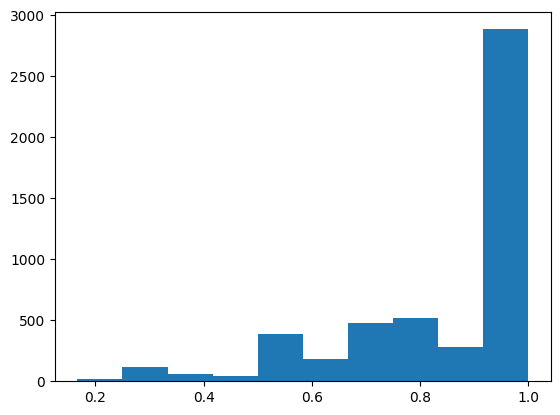

In [32]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(np.array(ious), bins = 10)

In [44]:
for coco_img, set1 in res["examples_good"]:
    hallucinations = set(data[coco_img]["chair_evals"]["mscoco_hallucinated_words"])
    if len(hallucinations) > 1 and len(results10[coco_img]["chair_evals"]["mscoco_hallucinated_words"]) == 0 and len(set(results10[coco_img]["chair_evals"]["recall_words"])) > len(set(data[coco_img]["chair_evals"]["recall_words"])):
        print(coco_img)

86137
58911
83626
64481
82255
51963
52648
93677
97219
107705
92380
103612
85281
52846
98956
56104
108836
71244
88068
84313
82716
46408
43809
51443
45622
101252
91639
94334
75546
59892
46492
45479
114269
70261
109908
72110
74984
76015
79355
42750


In [40]:
set(results10[target]["chair_evals"]["recall_words"])

{('man', 'person'), ('person', 'person'), ('umbrella', 'umbrella')}

In [41]:
set(data[target]["chair_evals"]["recall_words"])

{('man', 'person'), ('umbrella', 'umbrella')}

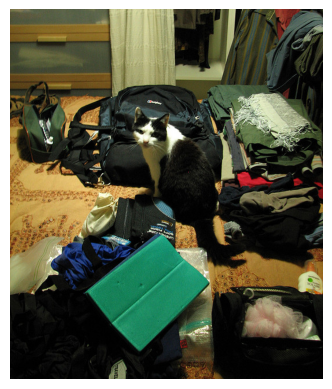

{'caption': '<s> The image depicts a black and white cat sitting in the middle of a cluttered room. The cat is surrounded by a variety of items, including suitcases, backpacks, clothes, and shoes. There are at least three suitcases scattered around the room, with one located closer to the cat and the other two further away. A backpack can be seen on the left side of the room, and a pair of shoes can be spotted on the right side. In addition to these items, there are several clothes spread out on the floor, including a shirt, a jacket, and a pair of pants. The cluttered environment suggests that the room may have been recently used for packing or preparing for a trip.', 'chair_evals': {'mscoco_hallucinated_words': [], 'mscoco_gt_words': ['bed', 'handbag', 'backpack', 'suitcase', 'cat'], 'mscoco_generated_words': ['cat', 'cat', 'suitcase', 'backpack', 'suitcase', 'cat', 'backpack'], 'hallucination_idxs': [], 'hallucinated_words': 0, 'recall_words': [('cat', 'cat'), ('cat', 'cat'), ('suit

In [50]:
target = 86137

image_path = coco_img_id_to_path(target, validation = False)
display_image(image_path)
print(results10[target])
print(data[target]["caption"], data[target]["chair_evals"])

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


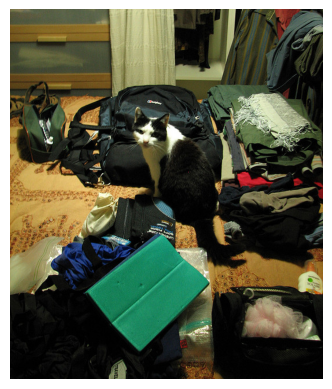

In [49]:
import matplotlib.pyplot as plt
from PIL import Image
from experiments.blip_utils import coco_img_id_to_path

def display_image(image_path):
    # Open an image file
    with Image.open(image_path) as img:
        # Display image
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.show()

# Example usage
image_path = coco_img_id_to_path(target, validation = False)
display_image(image_path)

### Experiment 11

In [8]:
def merge_experiment11A_results(directory, model):
    merged_results = {}

    for filename in os.listdir(directory):
        if filename.startswith(f"experiment11_{model}"):
            file_path = os.path.join(directory, filename)
            try:
                data = torch.load(file_path)
                if isinstance(data, dict):
                    for key, value in data.items():
                        if key not in merged_results:
                            merged_results[key] = value
                        else:
                            merged_results[key].update(value)
            except Exception as e:
                print(f"Failed to load {file_path}: {e}")

    return merged_results

In [110]:
model = "llava7b"

In [112]:
#Example usage:
directory_path = "/home/nickj/vl-hallucination/vl_results"
merged_results = merge_experiment_results(directory_path, startswith=f"experiment11_{model}")


Reading /home/nickj/vl-hallucination/vl_results/experiment11_llava7b_is_0_ie_30_w1_ss500_hTrue_gtFalse_sohTrue_yossi1.pt


In [65]:
data = torch.load(f"/home/nickj/vl-hallucination/vl_data/{model}_train.pt")

In [113]:
merged_results.keys()

dict_keys([4, 5, 6, 7, 8, 9, 10, 11, 24, 25, 12, 13, 14, 15, 20, 21, 22, 23, 16, 17, 18, 19, 28, 29, 30, 26, 27, 0, 1, 2, 3])

In [114]:
results_collections = []
results_collections_indices = []

In [115]:
for img_index in merged_results:
    for text_index in merged_results[img_index]:
        chair_evals = merged_results[img_index][text_index]
        results_collection = dict()
        for coco_img in chair_evals:
            h_before = get_unique_collection(data[coco_img]["chair_evals"]["mscoco_hallucinated_words"])
            recall_before = get_unique_collection(data[coco_img]["chair_evals"]["recall_words"])
            h_after = get_unique_collection(chair_evals[coco_img]["chair_evals"]["mscoco_hallucinated_words"])
            recall_after = get_unique_collection(chair_evals[coco_img]["chair_evals"]["recall_words"])
            # h_after = get_unique_collection(chair_evals[coco_img]["mscoco_hallucinated_words"])
            # recall_after = get_unique_collection(chair_evals[coco_img]["recall_words"])

            if len(h_before) == 0:
                continue
            results_collection[coco_img] = [h_before, recall_before, h_after, recall_after]
        results_collections.append(results_collection)
        results_collections_indices.append((img_index, text_index))

In [116]:
all_summary_stats = []

In [117]:
import numpy as np
reductions = np.zeros((32, 32))

In [118]:
for i in range(len(results_collections)):
    indices = results_collections_indices[i]
    print(f"Img index {indices[0]}, text index {indices[1]}, index {i}")

    res = compute_eval_diffs(results_collections[i])
    summary_stats = {key: value for key, value in res.items() if key != "check_results" and key != "classes_to_count"}

    print(summary_stats)
    print(res["hallucinations"][1] / res["hallucinations"][0])

    if res["recall"][1] > res["recall"][0]:
        reductions[indices[0]][indices[1]] = 1 - res["hallucinations"][1] / res["hallucinations"][0]
        
    else:
        reductions[indices[0]][indices[1]] = 0
    all_summary_stats.append(res)

Img index 4, text index 0, index 0
{'h_free_images': [0, 42], 'hallucinations': [815, 763], 'chair_i': [1.0, 0.9916], 'chair_s': [0.3735105407882676, 0.35905882352941176], 'recall': [1367, 1362], 'hallucinations_gained': 112, 'hallucinations_lost': 164, 'recall_lost': 35, 'recall_gained': 30, 'examples_good': [(80789, set()), (74365, set()), (113598, set()), (88117, set()), (54304, set()), (61328, set()), (52151, set()), (100322, set()), (97191, set()), (84949, set()), (80987, set()), (58250, set()), (74177, set()), (83641, set()), (100717, set()), (84284, set()), (51199, set()), (92914, set()), (82300, set()), (44943, set()), (73721, set()), (48111, set()), (96535, set()), (79613, set()), (92575, set()), (77325, set()), (41259, set()), (78684, set()), (101239, set()), (87525, set()), (89238, set()), (95243, set()), (49551, set()), (63644, set()), (97165, set()), (54949, set()), (105363, set()), (82106, set()), (109390, set()), (45941, set()), (78633, set()), (73610, set()), (98616, se

In [88]:
reductions[9][17]

0.24662576687116566

#### Removal rate

In [123]:
removals = [0, 0]
removal_rates = []
for img_index in merged_results:
    for text_index in merged_results[img_index]:
        chair_evals = merged_results[img_index][text_index]
        results_collection = dict()
        for coco_img in chair_evals:
            remove_objs = parse_h_objs(data[coco_img]["chair_evals"])
            mentioned_objs = parse_mentioned_objs(chair_evals[coco_img]["chair_evals"])
            removals[0] += len(remove_objs - mentioned_objs.intersection(remove_objs))
            removals[1] += len(remove_objs)
        removal_rates.append((removals[0] / removals[1], img_index, text_index))

In [124]:
for (rate, img_index, text_index) in removal_rates:
    if reductions[img_index][text_index] > 0:
        reductions[img_index][text_index] = rate

#### Heatmap

In [120]:
np.save("./experiments/plots/llava7b_hl.npy", reductions)

In [129]:
reductions = np.load("./experiments/plots/llava7b_hl.npy")

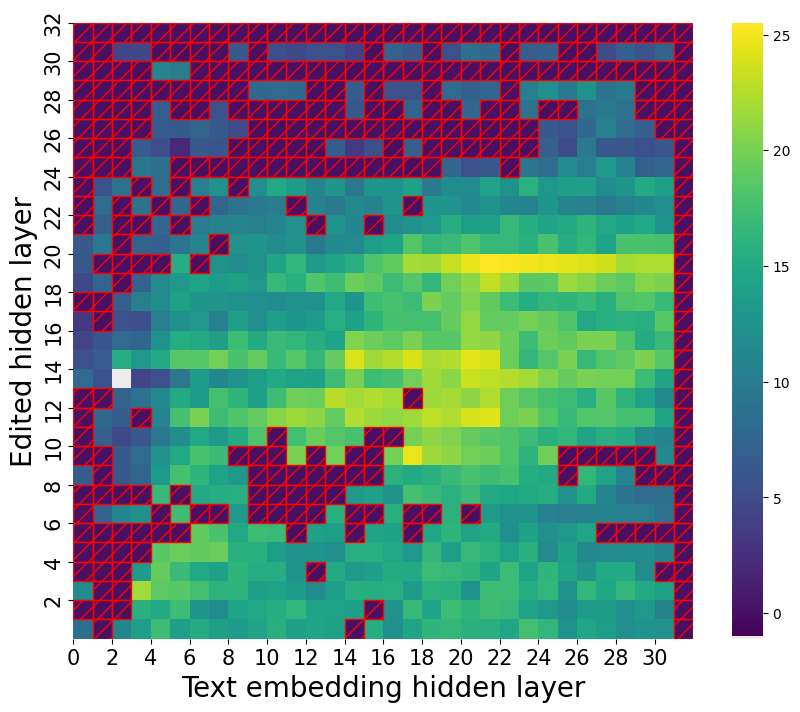

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch



# Create a custom colormap
cmap = plt.get_cmap("viridis")
newcolors = cmap(np.linspace(0, 1, 256))
light_gray = np.array([220/256, 220/256, 220/256, 0.5])  # Lighter gray color
newcolors[:1, :] = light_gray
newcmp = ListedColormap(newcolors)

# Create a mask for zero values
mask = reductions == 0

plt.figure(figsize=(10, 8))
ax = sns.heatmap(np.flipud(reductions) * 100, cmap=newcmp, xticklabels=range(reductions.shape[1]), yticklabels=range(reductions.shape[0]-1, -1, -1), cbar=True)

# Overlay hatch pattern for zero values
for i in range(reductions.shape[0]):
    for j in range(reductions.shape[1]):
        if mask[i, j]:
            plt.gca().add_patch(plt.Rectangle((j, reductions.shape[0] - 1 - i), 1, 1, fill=False, hatch='//', edgecolor='red'))

# Set ticks to show every 2 boxes
ax.set_xticks(np.arange(0, reductions.shape[1], 2))
ax.set_xticklabels(np.arange(0, reductions.shape[1], 2), fontsize=15)
ax.set_yticks(np.arange(0, reductions.shape[0], 2))
ax.set_yticklabels(np.arange(reductions.shape[0], 0, -2), fontsize=15)

# Set LaTeX labels
plt.xlabel(r'Text embedding hidden layer', fontsize=20)
plt.ylabel(r'Edited hidden layer', fontsize=20)
# plt.title("Removal rates")

# Create a custom legend
# legend_elements = []
# ax.legend(handles=legend_elements, loc='upper right')

plt.savefig("hallucination_reduction_heatmap1.pdf", format='pdf', bbox_inches="tight")
plt.show()

In [82]:
np.save("./experiments/plots/blip7b_hl_removal_rates.npy", reductions)

In [127]:
max_index = np.unravel_index(np.argmax(reductions, axis=None), reductions.shape)
max_value = reductions[max_index]

In [128]:
max_index, max_value

((19, 30), 0.43347175546374983)

In [85]:
reductions[15, 30]

0.0

In [88]:
reductions_h = np.load("./experiments/plots/blip7b_hl.npy")

In [126]:
max_index = np.unravel_index(np.argmax(reductions_h, axis=None), reductions.shape)
max_value = reductions_h[max_index]
print(max_index, max_value)

NameError: name 'reductions_h' is not defined

In [48]:
np.max(reductions_h)

0.24662576687116566

In [60]:
reductions_h[15,30]

0.16809815950920248

In [90]:
reductions[1,2]

0.7152396643716789

### Experiment 12

In [73]:
model = "llava7b"
directory_path = "/home/nickj/vl-hallucination/vl_results"
merged_results12 = merge_experiment_results(directory_path, startswith=f"experiment12A_{model}_il_9_tl_17")

Reading /home/nickj/vl-hallucination/vl_results/experiment12A_llava7b_il_9_tl_17_sw_2.0_ew_5.0_ss_1.0_sz_500_sh_True_rh_True_rg_False.pt
Reading /home/nickj/vl-hallucination/vl_results/experiment12A_llava7b_il_9_tl_17_sw_5.0_ew_10.0_ss_1.0_sz_500_sh_True_rh_True_rg_False.pt
Reading /home/nickj/vl-hallucination/vl_results/experiment12A_llava7b_il_9_tl_17_sw_0.5_ew_2.0_ss_0.5_sz_500_sh_True_rh_True_rg_False.pt


In [52]:
data = torch.load(f"/home/nickj/vl-hallucination/vl_data/{model}_train.pt")

In [89]:
results_collections = []
for weight in merged_results12:
    results_collection = dict()
    chair_evals = merged_results12[weight]
    for coco_img in chair_evals:
        h_before = get_unique_collection(data[coco_img]["chair_evals"]["mscoco_hallucinated_words"])
        recall_before = get_unique_collection(data[coco_img]["chair_evals"]["recall_words"])
        h_after = get_unique_collection(chair_evals[coco_img]["chair_evals"]["mscoco_hallucinated_words"])
        recall_after = get_unique_collection(chair_evals[coco_img]["chair_evals"]["recall_words"])
        # h_after = get_unique_collection(chair_evals[coco_img]["mscoco_hallucinated_words"])
        # recall_after = get_unique_collection(chair_evals[coco_img]["recall_words"])
    
        if len(h_before) == 0:
            continue
        results_collection[coco_img] = [h_before, recall_before, h_after, recall_after]
    results_collections.append((weight, results_collection))


In [90]:
results_collections.sort()

In [91]:
all_summary_stats = []
diffs_combined = dict(hallucinations=[], recall=[], removal_rate = [], new_hallucinations=[], recall_lost=[], recall_gained=[])
x_weights = []
for i in range(len(results_collections)):
    weight, collection = results_collections[i]
    print(f"Weight {weight}")

    res = compute_eval_diffs(collection)
    stats = {key: value for key, value in res.items() if not key.startswith("examples") and key != "classes_to_count"}

    print(stats)
    print(res["hallucinations"][1] / res["hallucinations"][0])

    # if len(diffs_combined["hallucinations"]) == 0:
    #     diffs_combined["hallucinations"].append(stats["chair_s"][0])
    #     diffs_combined["recall"].append(1-stats["chair_s"][0])
    #     diffs_combined["new_hallucinations"].append(0)
    #     diffs_combined["removal_rate"].append(0)
    #     diffs_combined["recall_lost"].append(0)
    #     diffs_combined["recall_gained"].append(0)
    #     x_weights.append(0)

    diffs_combined["hallucinations"].append(stats["hallucinations"][1] / stats["hallucinations"][0])
    diffs_combined["recall"].append(stats["recall"][1] / stats["recall"][0])
    # diffs_combined["new_hallucinations"].append(stats["hallucinations_gained"])
    diffs_combined["removal_rate"].append(stats["hallucinations_lost"] / stats["hallucinations"][0])
    # diffs_combined["recall_lost"].append(stats["recall_lost"])
    # diffs_combined["recall_gained"].append(stats["recall_gained"])
    x_weights.append(weight)

    all_summary_stats.append(res)

Weight 0.5
{'h_free_images': [0, 86], 'hallucinations': [815, 695], 'chair_i': [1.0, 0.9828], 'chair_s': [0.3735105407882676, 0.3357487922705314], 'recall': [1367, 1375], 'hallucinations_gained': 203, 'hallucinations_lost': 323, 'recall_lost': 51, 'recall_gained': 59}
0.852760736196319
Weight 1.0
{'h_free_images': [0, 123], 'hallucinations': [815, 651], 'chair_i': [1.0, 0.9754], 'chair_s': [0.3735105407882676, 0.3211642821904292], 'recall': [1367, 1376], 'hallucinations_gained': 267, 'hallucinations_lost': 431, 'recall_lost': 58, 'recall_gained': 67}
0.7987730061349694
Weight 1.5
{'h_free_images': [0, 132], 'hallucinations': [815, 615], 'chair_i': [1.0, 0.9736], 'chair_s': [0.3735105407882676, 0.3101361573373676], 'recall': [1367, 1368], 'hallucinations_gained': 282, 'hallucinations_lost': 482, 'recall_lost': 72, 'recall_gained': 73}
0.754601226993865
Weight 2.0
{'h_free_images': [0, 141], 'hallucinations': [815, 620], 'chair_i': [1.0, 0.9718], 'chair_s': [0.3735105407882676, 0.3115577

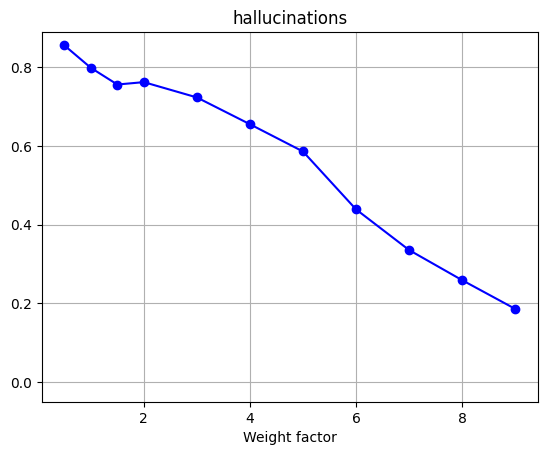

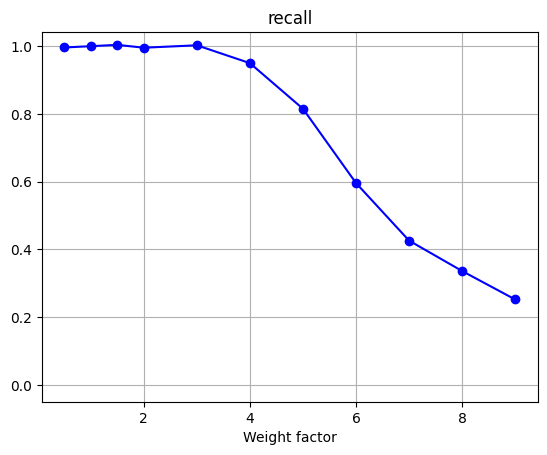

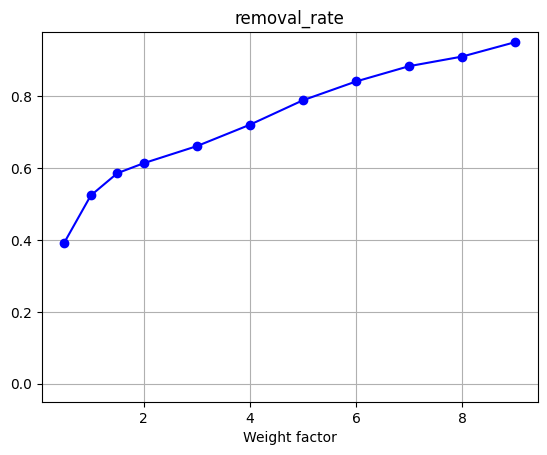

In [56]:
for key in diffs_combined:
    if len(diffs_combined[key]) == 0:
        continue
    plt.plot(x_weights, diffs_combined[key], marker='o', linestyle='-', color='b')
    plt.xlabel("Weight factor")
    plt.title(key)
    plt.ylim(-0.05)
    plt.grid(True)
    plt.show()

In [95]:
torch.save([x_weights, diffs_combined], "./llava7b_weight_ablations.pt")

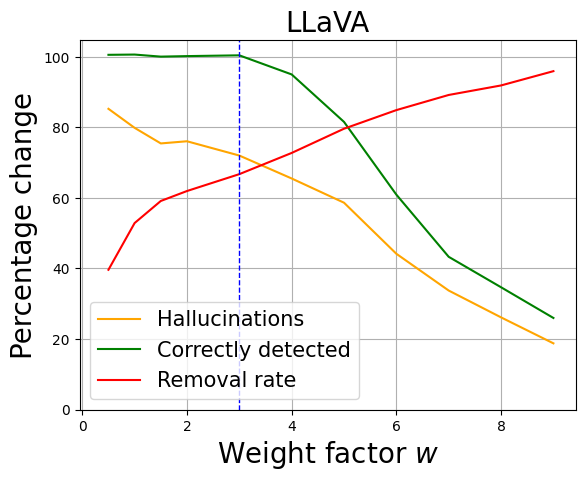

In [96]:

plt.plot(x_weights, np.array(diffs_combined["hallucinations"]) * 100, linestyle='-', color='orange', label='Hallucinations')
plt.plot(x_weights, np.array(diffs_combined["recall"]) * 100, linestyle='-', color='g', label='Correctly detected')
plt.plot(x_weights, np.array(diffs_combined["removal_rate"]) * 100, linestyle='-', color='r', label='Removal rate')

plt.xlabel(r"Weight factor $w$", fontsize=20)
plt.ylabel("Percentage change", fontsize=20)
plt.title("LLaVA", fontsize=20)
plt.xlim(-0.05)
plt.ylim(-0.05)
plt.axvline(x=3.0, color='blue', linestyle='--', linewidth=1)
plt.grid(True)
plt.legend(fontsize=15)  # Add legend with larger font size

# plt.show()
plt.savefig("./llava7b_weight_ablations.pdf", format="pdf", bbox_inches="tight")

In [26]:
diffs_combined["hallucinations"]

[0.852760736196319,
 0.7987730061349694,
 0.754601226993865,
 0.7607361963190185,
 0.7202453987730061,
 0.6552147239263804,
 0.5865030674846625,
 0.44171779141104295,
 0.3374233128834356,
 0.26134969325153373,
 0.18773006134969325]

In [58]:
merged_results1.keys()

dict_keys([4, 5, 6, 7, 8, 9, 10, 11, 24, 25, 12, 13, 14, 15, 20, 21, 22, 23, 16, 17, 18, 19, 28, 29, 30, 26, 27, 0, 1, 2, 3])

In [38]:
merged_results1 = merge_experiment_results(directory_path, startswith=f"experiment11_{model}")

Reading /home/nickj/vl-hallucination/vl_results/experiment11_llava7b_is_0_ie_30_w1_ss500_hTrue_gtFalse_sohTrue_yossi.pt


In [62]:
set(merged_results1[9][17].keys()), set(merged_results[1].keys())

({40844,
  40866,
  40874,
  41001,
  41146,
  41259,
  41561,
  41742,
  41840,
  42578,
  42658,
  42698,
  42785,
  42858,
  42861,
  43001,
  43077,
  44471,
  44928,
  44943,
  45063,
  45678,
  45829,
  45923,
  45941,
  46104,
  46118,
  46211,
  46267,
  46356,
  46385,
  46492,
  46564,
  46660,
  46848,
  47066,
  47074,
  47235,
  47387,
  47418,
  47857,
  47928,
  47974,
  48111,
  48189,
  48417,
  48711,
  48772,
  48794,
  49062,
  49118,
  49141,
  49240,
  49257,
  49315,
  49542,
  49549,
  49551,
  49586,
  49719,
  50178,
  50536,
  50691,
  50939,
  51168,
  51199,
  51281,
  51328,
  51894,
  51898,
  51941,
  52151,
  52222,
  52348,
  52406,
  52472,
  52503,
  52648,
  52948,
  53121,
  53150,
  53176,
  53330,
  53546,
  53696,
  53733,
  53977,
  54229,
  54304,
  54336,
  54374,
  54943,
  54949,
  55569,
  55608,
  55641,
  55645,
  55712,
  55747,
  55882,
  55902,
  56261,
  56303,
  56397,
  56432,
  56442,
  56892,
  57050,
  57147,
  57300,
  57466,
 

In [78]:
count = 0
for coco_img in merged_results12[1]:
    if merged_results12[1][coco_img]["caption"] != merged_results[9][17][coco_img]["caption"]:
        print(coco_img)
        count += 1
print(count)

108075
64389
80234
95096
80386
58677
81944
83619
66096
61377
68667
63049
52503
114269
74365
53977
65891
50536
71244
112590
95506
56397
54304
60684
69675
69770
58640
89949
78614
52151
67565
59515
97191
100827
46356
56432
84949
80987
51328
47074
87126
74900
85759
81894
109638
85235
57050
58250
74177
86668
97743
47066
105119
73860
98694
55645
50691
81200
112453
85171
80401
113437
95535
59874
58325
49719
80246
51941
82300
108293
74863
80077
105768
96535
79613
89741
88185
54943
86137
103419
97373
46267
110758
102632
41259
89914
53121
78684
102739
70491
84875
107975
77378
67334
53176
83878
52222
104792
44471
85211
87685
81084
80295
42658
108897
46211
89238
99808
57300
43001
60402
101426
72538
110979
102311
49551
67414
105358
109444
105520
68565
93579
105363
85893
67802
63626
75557
50939
98887
81476
55712
112124
70033
109477
109390
83348
84603
90823
73610
83884
93600
46385
42785
46104
109487
47387
93644
49549
56261
95044
104044
53696
101014
53733
103897
86927
66273
99108
78065
53150
114202
86